In [1]:
import re
import os
import glob
import zipfile
import requests
from urllib.request import urlretrieve
import json
import pandas as pd
import numpy as np

# 3. Download Data

### 3.1 Download with figshare API

In [2]:
# Use API to download data
article_id = "14096681"
url = f"https://api.figshare.com/v2/articles/{article_id}"
headers = {"Content-Type": "application/json"}
output_directory = "NSWrainfall/"
response = requests.request("GET", url, headers=headers)
data = json.loads(response.text)  
files = data["files"]     

## 3.2 Extract Zip File

In [6]:
%%time
# create zip file
files_to_dl = ["data.zip"]
for file in files:
    if file["name"] in files_to_dl:
        os.makedirs(output_directory, exist_ok=True)
        urlretrieve(file["download_url"], output_directory + file["name"])

CPU times: user 4.24 s, sys: 5.4 s, total: 9.64 s
Wall time: 2min 6s


In [7]:
%%time
# extract data into directory
with zipfile.ZipFile(os.path.join(output_directory, "data.zip"), 'r') as f:
    f.extractall(output_directory)

CPU times: user 17.2 s, sys: 5.86 s, total: 23 s
Wall time: 32 s


# 4. Combine CSV

In [3]:
%%time

if os.path.exists("NSWrainfall/combined_data.csv"):
  df = pd.read_csv("NSWrainfall/combined_data.csv")
  
else:
  excluded_files = ["NSWrainfall\\observed_daily_rainfall_SYD.csv"]
  files = glob.glob('NSWrainfall/*.csv')
  files = list(set(files) - set(excluded_files))
  df = pd.concat((pd.read_csv(file, index_col=0)
                  .assign(model=re.findall("/([^_]*)", file)[0])  
                  for file in files)
                )
  df.to_csv("NSWrainfall/combined_data.csv")

CPU times: user 1min, sys: 12.2 s, total: 1min 12s
Wall time: 1min 21s


| Team Member | Operating System | RAM | Processor | Is SSD | Time Taken |
| --- | --- | --- | --- | --- | --- |
| Austin Shih | MacOS | 64GB | Intel i9 2.4 GHz 8-Core | Yes | 6m 20s |
| Renee Kwon | MacOS | 8GB | Dual-Core Intel Core i5 | Yes | 12min 27s |
| Wilfred Hass | Ubuntu 22.04 | 16GB | Intel i7-7700HQ 2.8 GHz 4-core | Yes | 6m 44s |
| Fujie Sun | WinOS | 16GB | AMD Ryzen 7 5800HS  | Yes | 8min 34s  |

In [3]:
df.head()

,time,lat_min,lat_max,lon_min,lon_max,rain (mm/day),model
0,1889-01-01 12:00:00,-36.0,-35.0,141.25,142.5,1.387707e-05,GFDL-CM4
1,1889-01-02 12:00:00,-36.0,-35.0,141.25,142.5,2.036512e-05,GFDL-CM4
2,1889-01-03 12:00:00,-36.0,-35.0,141.25,142.5,1.801581e-10,GFDL-CM4
3,1889-01-04 12:00:00,-36.0,-35.0,141.25,142.5,1.192193e-03,GFDL-CM4
4,1889-01-05 12:00:00,-36.0,-35.0,141.25,142.5,4.229841e-04,GFDL-CM4


**Comparisons:**

The time taken to combine the multiple csv files into one file varied for the members of our group depending on the specifications of our machines. Austin's MacOS machine with 64GB and an Intel i9 processor took the shortest time to merge the files. Wilfred's Ubuntu machine with 16GB RAM and an Intel i7 processor was just 24 seconds behind Austin, indicating that having a much higher RAM is not a significant component on the performance of merging a dataset of this size. As well, Fujie's Windows machine with the same 16GB took almost two minutes longer than Wilfred, further indicating that the processor of the machine or the operating system (or other factors not measured here) has a larger impact on the processing time of this task. Furthermore, Renee's MacOS computer with the older Intel i5 processor took the longest time, almost double the time of Austin's on the same OS but with an i9 processor. All members have SSD so we were not able to compare the results of SSD vs. HDD. 

# 5. Simple EDA

| Team Member | Operating System | RAM | Processor | Is SSD | Time Taken to Naively Load CSV | Changing dtype | Loading only Certain Columns |
| --- | --- | --- | --- | --- | --- | --- | --- |
| Austin Shih | MacOS | 64GB | Intel i9 2.4 GHz 8-Core | Yes | --- | --- | --- |
| Renee Kwon | MacOS | 8GB | Dual-Core Intel Core i5  | Yes | --- | --- | --- |
| Wilfred Hass | Ubuntu 22.04 | 16GB | Intel i7-7700HQ 2.8 GHz 4-core | Yes | 1m 30s | 1m 27s | 50.6s |
| Fujie Sun | WinOS | 16GB | AMD Ryzen 7 5800HS  | Yes | --- | --- | --- |

**Note** There will be memory issues if you run any two of the sections in one session. Please restart your kernel each time.

Let's say we are interested in the mean `lat_min` and median `lon_min`, along with the distribution of rain over the entire dataset. To perform this EDA, we use the `describe()` function and use pandas' built-in histogram plotting.

We find that loading the combined data with `dtype` that consume less memory only marginally speeds up the EDA (by about 21%). This also reduces our memory consumptions by a third with this dataset when going from `float64` to `float32`, trading precision for memory (3.50 GB to 2.25 GB). When loading only the three columns we actually use for the EDA, the amount of memory consumed is only 1.5 GB and the EDA takes 50.7s, which is much faster than  the other method or leaving it as is!

In [3]:
# Install matplotlib if it isn't already installed

# !pip install matplotlib

## 5.1 Control Time (No changes to loading the data)

Memory Usage 3500.776456 MB
            lat_min       lat_max       lon_min       lon_max  rain (mm/day)
count  5.924854e+07  6.246784e+07  5.924854e+07  6.246784e+07   5.929456e+07
mean  -3.310482e+01 -3.197757e+01  1.469059e+02  1.482150e+02   1.901827e+00
std    1.963549e+00  1.992067e+00  3.793784e+00  3.809994e+00   5.588275e+00
min   -3.646739e+01 -3.600000e+01  1.406250e+02  1.412500e+02  -3.807373e-12
25%   -3.486911e+01 -3.366221e+01  1.434375e+02  1.450000e+02   3.876672e-06
50%   -3.300000e+01 -3.204188e+01  1.468750e+02  1.481250e+02   6.161705e-02
75%   -3.140170e+01 -3.015707e+01  1.501875e+02  1.513125e+02   1.021314e+00
max   -2.990000e+01 -2.790606e+01  1.537500e+02  1.556250e+02   4.329395e+02
CPU times: user 1min 7s, sys: 15.2 s, total: 1min 22s
Wall time: 1min 30s


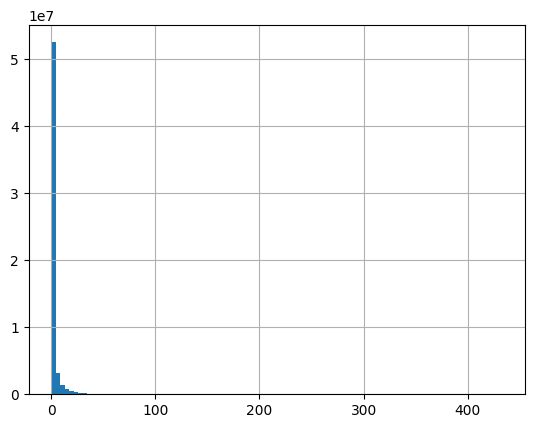

In [2]:
%%time
df = pd.read_csv("NSWrainfall/combined_data.csv")
print("Memory Usage", df.memory_usage().sum() / 1e6 , "MB")
print(df.describe())
df["rain (mm/day)"].hist(bins=100);

## 5.1 Changing dtype 

Memory Usage 2250.499196 MB
            lat_min       lat_max       lon_min       lon_max  rain (mm/day)
count  5.924854e+07  6.246784e+07  5.924854e+07  6.246784e+07   5.929456e+07
mean  -3.310527e+01 -3.197716e+01  1.469070e+02  1.482140e+02   1.901827e+00
std    1.963549e+00  1.992067e+00  3.793784e+00  3.809994e+00   5.588274e+00
min   -3.646739e+01 -3.600000e+01  1.406250e+02  1.412500e+02  -3.807373e-12
25%   -3.486911e+01 -3.366221e+01  1.434375e+02  1.450000e+02   3.876672e-06
50%   -3.300000e+01 -3.204189e+01  1.468750e+02  1.481250e+02   6.161705e-02
75%   -3.140170e+01 -3.015707e+01  1.501875e+02  1.513125e+02   1.021314e+00
max   -2.990000e+01 -2.790606e+01  1.537500e+02  1.556250e+02   4.329395e+02
CPU times: user 1min 11s, sys: 10.7 s, total: 1min 22s
Wall time: 1min 27s


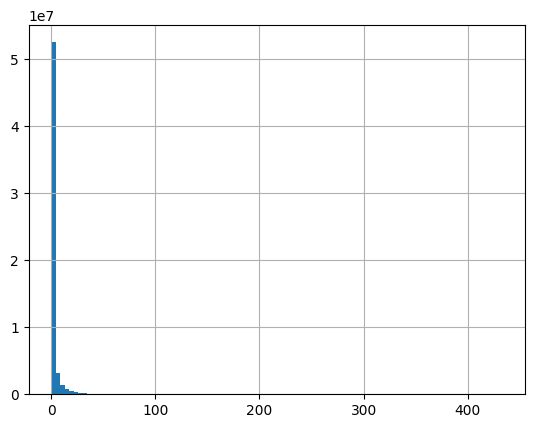

In [3]:
%%time
df_dtype = pd.read_csv("NSWrainfall/combined_data.csv",
                       dtype={'lat_min': np.float32,
                              'lat_max': np.float32,
                              'lon_min': np.float32,
                              'lon_max': np.float32,
                              'rain (mm/day)': np.float32,
                              'model': str})
print("Memory Usage", df_dtype.memory_usage().sum() / 1e6 , "MB")
print(df_dtype.describe())
df_dtype["rain (mm/day)"].hist(bins=100);

## 5.2 Load Only Columns Needed

Memory Usage 1500.33284 MB
            lat_min       lon_min  rain (mm/day)
count  5.924854e+07  5.924854e+07   5.929456e+07
mean  -3.310482e+01  1.469059e+02   1.901827e+00
std    1.963549e+00  3.793784e+00   5.588275e+00
min   -3.646739e+01  1.406250e+02  -3.807373e-12
25%   -3.486911e+01  1.434375e+02   3.876672e-06
50%   -3.300000e+01  1.468750e+02   6.161705e-02
75%   -3.140170e+01  1.501875e+02   1.021314e+00
max   -2.990000e+01  1.537500e+02   4.329395e+02
CPU times: user 40.9 s, sys: 6.6 s, total: 47.5 s
Wall time: 50.6 s


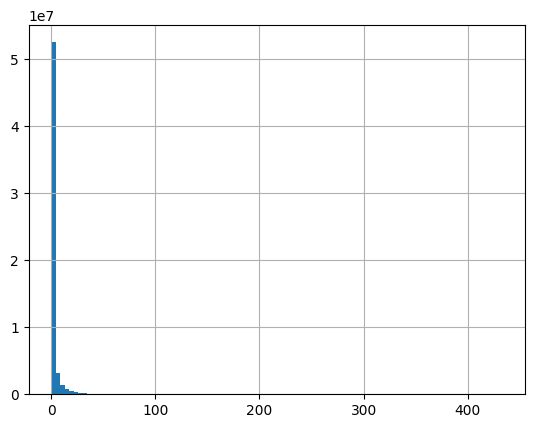

In [2]:
%%time
df_cols = pd.read_csv("NSWrainfall/combined_data.csv",
                      usecols=['lat_min', 'lon_min', "rain (mm/day)"])
print("Memory Usage", df_cols.memory_usage().sum() / 1e6 , "MB")
print(df_cols.describe())
df_cols["rain (mm/day)"].hist(bins=100);